In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.utils import to_categorical
from keras.preprocessing import image


EMOTIONS = [
    "angry",
    "calm",
    "disgust",
    "fear",
    "sad",
    "happy",
    "neutral",
    "surprise"
]
DATA_PATH = 'data/'

IMG_WIDTH, IMG_HEIGHT = 100, 100
SEQ_LENGTH = 2
OVERLAP_IDX = int(0.9 * SEQ_LENGTH)
SEQUENCE_PATH = 'sequence/'

Using TensorFlow backend.


In [2]:
model = InceptionResNetV2(include_top=False, weights='imagenet')

219062272/219055592 [==============================] - 10s 0us/step


In [3]:
def extract_feature_sequence():
    X, y = [], []
    for emotion in EMOTIONS:
        print(emotion)
        video_list = [f for f in os.listdir(DATA_PATH + emotion)]
        for video in video_list:
            video_path = DATA_PATH + emotion + '/' + video + '/' + video + '_aligned'
            frames = [f for f in os.listdir(video_path) if os.path.isfile(os.path.join(video_path, f))]
            if len(frames) >= SEQ_LENGTH:
                X, y = process_frames(frames, video_path, emotion, X, y)
        print('{} sequences extracted'.format(emotion))
    # use onehot encoding for LSTM
    y = to_categorical(y, num_classes=len(EMOTIONS))
    # save to binary files
    print('Saving sequence')
    np.save(SEQUENCE_PATH + 'X_InceptionResNetV2', X)
    np.save(SEQUENCE_PATH + 'y_InceptionResNetV2', y)
    print('Saving finished')


def process_frames(frames, video_path, emotion, X, y):
    sequence = []
    for frame in frames:
        frame = video_path + '/' + frame
        features = extract_features(model, frame)
        sequence.append(features)
        if len(sequence) == SEQ_LENGTH:
            X.append(sequence)
            y.append(EMOTIONS.index(emotion))
            
            sequence = sequence[OVERLAP_IDX:]
    return X, y


def extract_features(model, image_path):
    # load and preprocess the frame
    img = image.load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    # Get the prediction.
    features = model.predict(x)
    features = features[0]
    return features

extract_feature_sequence()

angry
angry sequences extracted
calm
calm sequences extracted
disgust
disgust sequences extracted
fear
fear sequences extracted
sad
sad sequences extracted
happy
happy sequences extracted
neutral
neutral sequences extracted
surprise
surprise sequences extracted
Saving sequence
Saving finished


In [4]:
from sklearn.model_selection import train_test_split

def split_dataset(X, y, test_size=0.2, val_split=True):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    if val_split:
        X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)
        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        return X_train, y_train, X_test, y_test

def load_sequence():
    X = np.load(SEQUENCE_PATH + 'X_InceptionResNetV2.npy')
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2] * X.shape[3] * X.shape[4])
    y = np.load(SEQUENCE_PATH + 'y_InceptionResNetV2.npy')
    X_train, y_train, X_val, y_val, X_test, y_test = split_dataset(X, y, test_size=0.2)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [5]:
X_train, y_train, X_val, y_val, X_test, y_test = load_sequence()

In [6]:
import matplotlib.pyplot as plt
import time
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, title='Confusion matrix', float_display='.4f', cmap=plt.cm.Greens, class_names=None):
    # create confusion matrix plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks)
    ax = plt.gca()
    ax.set_xticklabels(class_names)
    plt.yticks(tick_marks)
    ax.set_yticklabels(class_names)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], float_display),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

def get_predictions_and_labels(model, X, y):
    predictions = model.predict(X)
    y_true = []
    y_pred = []
    for i in range(len(y)):
        label = list(y[i]).index(1)
        pred = list(predictions[i])
        max_value = max(pred)
        max_index = pred.index(max_value)
        p = max_index
        y_true.append(label)
        y_pred.append(p)
    return y_true, y_pred

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [9]:
class LSTMNetwork:
    def __init__(self, n_layer, lstm_unit, input_shape, feature, data_type):
        self.EMOTIONS = [
            "angry",
            "calm",
            "disgust",
            "fear",
            "sad",
            "happy",
            "neutral",
            "surprise"
        ]

        self.model = Sequential()
        if n_layer > 1:
            self.model.add(LSTM(lstm_unit, return_sequences=True, input_shape=input_shape,
                                dropout=0.2))
            layer_count = 1
            while layer_count < n_layer:
                if layer_count == n_layer - 1:
                    self.model.add(LSTM(lstm_unit, return_sequences=False, dropout=0.2))
                else:
                    self.model.add(LSTM(lstm_unit, return_sequences=True, dropout=0.2))
                layer_count += 1
        else:
            self.model.add(LSTM(lstm_unit, return_sequences=False, input_shape=input_shape,
                                dropout=0.2))
        nb_class = len(self.EMOTIONS)
        self.model.add(Dense(nb_class, activation='softmax'))

        current_time = time.strftime("%Y%m%d-%H%M%S")
        self.base_dir = 'LSTM/' + data_type + '/' + feature + '/'
        self.model_dir = 'LSTM_' + str(n_layer) + '_' + str(lstm_unit) + '_' + current_time + '/'
        filename = 'LSTM.h5'
        self.model_file = self.base_dir + self.model_dir + filename

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        # compile and train the model
        if not os.path.exists(self.base_dir + self.model_dir):
            os.makedirs(self.base_dir + self.model_dir)
        log_dir = self.base_dir + self.model_dir + 'log/'
        os.mkdir(log_dir)
        self.model.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        callbacks = [ModelCheckpoint(self.model_file, monitor='val_loss', save_best_only=True, verbose=0),
                     TensorBoard(log_dir=log_dir, write_graph=True)]
        self.model.fit(X_train, y_train,
                       epochs=epochs,
                       batch_size=batch_size,
                       validation_data=(X_val, y_val),
                       callbacks=callbacks)

    def evaluate(self, X_val, y_val):
        # evaluate_vgg16 the model with validation set
        model = load_model(self.model_file)
        scores = model.evaluate(X_val, y_val)
        print('val_loss: {}, val_acc: {}'.format(scores[0], scores[1]))

        y_true, y_pred = get_predictions_and_labels(model, X_val, y_val)
        cm = confusion_matrix(y_true, y_pred)
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        df = pd.DataFrame(cm_percent, index=self.EMOTIONS, columns=self.EMOTIONS)
        df.index.name = 'Actual'
        df.columns.name = 'Predicted'
        df.to_csv(self.base_dir + self.model_dir + 'cm_val.csv', float_format='%.4f')

        # plot percentage confusion matrix
        fig1, ax1 = plt.subplots()
        plot_confusion_matrix(cm_percent, class_names=self.EMOTIONS)
        plt.savefig(self.base_dir + self.model_dir + 'cm_percent_val.png', format='png')
        # plot normal confusion matrix
        fig2, ax2 = plt.subplots()
        plot_confusion_matrix(cm, float_display='.0f', class_names=self.EMOTIONS)
        plt.savefig(self.base_dir + self.model_dir + 'cm_val.png', format='png')

        plt.show()

    def compare_model(self, X_val, y_val):
        folder_list = [model_dir for model_dir in os.listdir(self.base_dir) if 'LSTM' in model_dir]
        for folder in folder_list:
            filename = 'LSTM.h5'
            path = os.path.join(self.base_dir, folder, filename)
            model = load_model(path)
            scores = model.evaluate(X_val, y_val)
            print('model: {}, val_loss: {}, val_acc: {}'.format(folder, scores[0], scores[1]))

            y_true, y_pred = get_predictions_and_labels(model, X_val, y_val)
            cm = confusion_matrix(y_true, y_pred)
            cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

            # plot percentage confusion matrix
            fig1, ax1 = plt.subplots()
            plot_confusion_matrix(cm_percent, class_names=self.EMOTIONS)
            plt.savefig(os.path.join(self.base_dir, folder, 'cm_percent_test.png'), format='png')
            # plot normal confusion matrix
            fig2, ax2 = plt.subplots()
            plot_confusion_matrix(cm, float_display='.0f', class_names=self.EMOTIONS)
            plt.savefig(os.path.join(self.base_dir, folder, 'cm_test.png'), format='png')

In [10]:
feature = 'InceptionResNetV2'
data_type = 'Basic'
n_layer = 1
lstm_unit = 32
batch_size = 256
epochs = 250
lstm_net = LSTMNetwork(n_layer, lstm_unit, X_train.shape[1:], feature, data_type)

In [11]:
lstm_net.train(X_train, y_train, X_test, y_test, epochs, batch_size)

Train on 126613 samples, validate on 15827 samples
Epoch 1/250
126613/126613 [==============================] - 16s 130us/step - loss: 1.1250 - acc: 0.6106 - val_loss: 0.6597 - val_acc: 0.7878
Epoch 2/250
126613/126613 [==============================] - 5s 38us/step - loss: 0.6582 - acc: 0.7768 - val_loss: 0.4375 - val_acc: 0.8643
Epoch 3/250
126613/126613 [==============================] - 5s 38us/step - loss: 0.5009 - acc: 0.8305 - val_loss: 0.3731 - val_acc: 0.8753
Epoch 4/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.4207 - acc: 0.8588 - val_loss: 0.3213 - val_acc: 0.8944
Epoch 5/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.3656 - acc: 0.8767 - val_loss: 0.2614 - val_acc: 0.9162
Epoch 6/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.3305 - acc: 0.8890 - val_loss: 0.2137 - val_acc: 0.9315
Epoch 7/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.3018 - acc: 0.8983 - va

Epoch 59/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1437 - acc: 0.9503 - val_loss: 0.0881 - val_acc: 0.9704
Epoch 60/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1373 - acc: 0.9527 - val_loss: 0.0900 - val_acc: 0.9696
Epoch 61/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1402 - acc: 0.9517 - val_loss: 0.0777 - val_acc: 0.9740
Epoch 62/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1378 - acc: 0.9528 - val_loss: 0.0932 - val_acc: 0.9680
Epoch 63/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1384 - acc: 0.9520 - val_loss: 0.0682 - val_acc: 0.9768
Epoch 64/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1361 - acc: 0.9535 - val_loss: 0.0807 - val_acc: 0.9732
Epoch 65/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1356 - acc: 0.9537 - val_loss: 0.0849 - val_acc: 0.9720
Epoch 66/250


Epoch 117/250
126613/126613 [==============================] - 5s 38us/step - loss: 0.1209 - acc: 0.9583 - val_loss: 0.0650 - val_acc: 0.9776
Epoch 118/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1217 - acc: 0.9582 - val_loss: 0.0707 - val_acc: 0.9762
Epoch 119/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1188 - acc: 0.9590 - val_loss: 0.0740 - val_acc: 0.9747
Epoch 120/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1236 - acc: 0.9575 - val_loss: 0.0666 - val_acc: 0.9771
Epoch 121/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1237 - acc: 0.9575 - val_loss: 0.0705 - val_acc: 0.9764
Epoch 122/250
126613/126613 [==============================] - 5s 38us/step - loss: 0.1187 - acc: 0.9594 - val_loss: 0.0694 - val_acc: 0.9767
Epoch 123/250
126613/126613 [==============================] - 5s 38us/step - loss: 0.1207 - acc: 0.9587 - val_loss: 0.0762 - val_acc: 0.9742
Epoch 

126613/126613 [==============================] - 5s 37us/step - loss: 0.1140 - acc: 0.9600 - val_loss: 0.0649 - val_acc: 0.9773
Epoch 175/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1136 - acc: 0.9611 - val_loss: 0.0654 - val_acc: 0.9785
Epoch 176/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1156 - acc: 0.9597 - val_loss: 0.0628 - val_acc: 0.9790
Epoch 177/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1132 - acc: 0.9607 - val_loss: 0.0669 - val_acc: 0.9762
Epoch 178/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1157 - acc: 0.9594 - val_loss: 0.0766 - val_acc: 0.9745
Epoch 179/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1161 - acc: 0.9593 - val_loss: 0.0612 - val_acc: 0.9797
Epoch 180/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1172 - acc: 0.9592 - val_loss: 0.0659 - val_acc: 0.9793
Epoch 181/250
126613

Epoch 232/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1095 - acc: 0.9623 - val_loss: 0.0651 - val_acc: 0.9780
Epoch 233/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1135 - acc: 0.9606 - val_loss: 0.0606 - val_acc: 0.9799
Epoch 234/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1083 - acc: 0.9624 - val_loss: 0.0623 - val_acc: 0.9791
Epoch 235/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1102 - acc: 0.9622 - val_loss: 0.0627 - val_acc: 0.9799
Epoch 236/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1132 - acc: 0.9616 - val_loss: 0.0599 - val_acc: 0.9790
Epoch 237/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1116 - acc: 0.9615 - val_loss: 0.0556 - val_acc: 0.9823
Epoch 238/250
126613/126613 [==============================] - 5s 37us/step - loss: 0.1132 - acc: 0.9614 - val_loss: 0.0739 - val_acc: 0.9757
Epoch 

15827/15827 [==============================] - 3s 176us/step
val_loss: 0.060687269525426045, val_acc: 0.9793391040890398


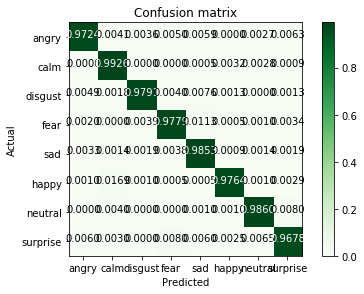

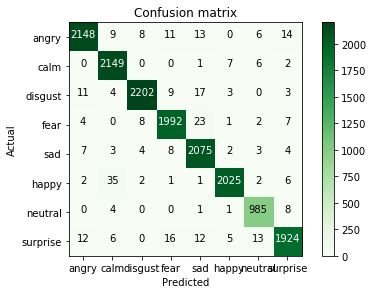

In [13]:
lstm_net.evaluate(X_val, y_val)